# Autoencoders in SciKeras

Autencoders are an approach to use nearual networks to distill data into it's most important features, thereby compressing the data. We will be following the [Keras tutorial](https://blog.keras.io/building-autoencoders-in-keras.html) on the topic, which goes much more in depth and breadth than we will here. You are highly encouraged to check out that tutorial if you want to learn about autoencoders in the general sense.

## Table of contents

* [1. Setup](#1.-Setup)
* [2. Data](#2.-Data)
* [3. Define Keras Model](#3.-Define-Keras-Model)
* [4. Training](#4.-Training)
* [5. Explore Results](#5.-Explore-Results)

## 1. Setup

In [1]:
try:
    import scikeras
except ImportError:
    !python -m pip install scikeras

Silence TensorFlow logging to keep output succinct.

In [2]:
import warnings
from tensorflow import get_logger
get_logger().setLevel('ERROR')
warnings.filterwarnings("ignore", message="Setting the random state for TF")

In [3]:
import numpy as np
from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow import keras

## 2. Data

We load the dataset from the Keras tutorial. The dataset consists of images of cats and dogs.

In [4]:
from tensorflow.keras.datasets import mnist
import numpy as np


(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


## 3. Define Keras Model

We will be defining a very simple autencoder. We define _three_ model building methods:

1. One to build a full end-to-end autoencoder.
2. One to create a model that includes only the encoder portion.
3. One that creates a model that includes only the decoder portion.

The only variable we give our model is the encoding dimensions, which will be a hyperparemter of our final transformer.

In [5]:
from tensorflow import keras


def get_fit_model(encoding_dim: int) -> keras.Model:
    """Get an autoencoder.

    This autoencoder compresses a 28x28 image (784 pixels) down to a feature of length
    `encoding_dim`, and tries to reconstruct the input image from that vector.
    """
    input_img = keras.Input(shape=(784,), name="input")
    encoded = keras.layers.Dense(encoding_dim, activation='relu', name="encoded")(input_img)
    decoded = keras.layers.Dense(784, activation='sigmoid', name="output")(encoded)
    autoencoder_model = keras.Model(input_img, decoded)
    return autoencoder_model

def get_tf_model(fit_model: keras.Model) -> keras.Model:
    """Get an encoder model.

    We do this by extracting the encoding layer from the fitted autoencoder model.
    """
    return keras.Model(fit_model.get_layer("input").input, fit_model.get_layer("encoded").output)

def get_inverse_tf_model(fit_model: keras.Model, encoding_dim: int) -> keras.Model:
    """Get an deencoder model.

    We do this by extracting the deencoding layer from the fitted autoencoder model
    and adding a new Keras input layer.
    """
    encoded_input = keras.Input(shape=(encoding_dim,))
    output = fit_model.get_layer("output")(encoded_input)
    return keras.Model(encoded_input, output)

Next we create a class that that will enable the `transform` and `fit_transform` methods, as well as integrating all three of our models into a single estimator.

In [6]:
from sklearn.base import TransformerMixin, clone
from scikeras.wrappers import BaseWrapper


class KerasTransformer(BaseWrapper, TransformerMixin):
    """A class that enables transform and fit_transform.
    """

    def __init__(self, *args, tf_est: BaseWrapper = None, inv_tf_est: BaseWrapper = None, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.tf_est = tf_est
        self.inv_tf_est = inv_tf_est


    def fit(self, X, sample_weight=None):
        super().fit(X=X, y=X, sample_weight=sample_weight)
        self.tf_est_ = clone(self.tf_est)
        self.inv_tf_est_ = clone(self.inv_tf_est)
        self.tf_est_.set_params(fit_model=self.model_)
        self.inv_tf_est_.set_params(fit_model=self.model_, encoding_dim=self.encoding_dim)
        X = self.feature_encoder_.transform(X)
        self.tf_est_.initialize(X=X)
        X_tf = self.tf_est_.predict(X=X)
        self.inv_tf_est_.initialize(X_tf)
        return self

    def transform(self, X):
        X = self.feature_encoder_.transform(X)
        X_tf = self.tf_est_.predict(X)
        return X_tf
    
    def inverse_transform(self, X_tf):
        X = self.inv_tf_est_.predict(X_tf)
        X = self.feature_encoder_.inverse_transform(X)
        return X

Next, we wrap the Keras Model with Scikeras. Note that for our encoder/decoder estimators, we do not need to provide a loss function since no training will be done. We do however need to have the `fit_model` and `encoding_dim` so that these will be settable by `BaseWrapper.set_params`.

In [7]:
tf_est = BaseWrapper(model=get_tf_model, fit_model=None, verbose=0)
inv_tf_est = BaseWrapper(model=get_inverse_tf_model, fit_model=None, encoding_dim=None, verbose=0)
autoencoder = KerasTransformer(model=get_fit_model, tf_est=tf_est, inv_tf_est=inv_tf_est, loss="binary_crossentropy", encoding_dim=32, epochs=5)

## 4. Training

To train the model, we pass the input images as both the features and the target. This will train the layers to compress the data as accurately as possible between the encoder and decoder. Note that we only pass the `X` parameter, since we defined the mapping `y=X` in `KerasTransformer.fit` above.

In [8]:
_ = autoencoder.fit(X=x_train)

Epoch 1/5


   1/1875 [..............................] - ETA: 12:32 - loss: 0.6930

  32/1875 [..............................] - ETA: 3s - loss: 0.5355   

  69/1875 [>.............................] - ETA: 2s - loss: 0.4480

 100/1875 [>.............................] - ETA: 2s - loss: 0.4109

 132/1875 [=>............................] - ETA: 2s - loss: 0.3855

 167/1875 [=>............................] - ETA: 2s - loss: 0.3652

 202/1875 [==>...........................] - ETA: 2s - loss: 0.3495

 228/1875 [==>...........................] - ETA: 2s - loss: 0.3397

 254/1875 [===>..........................] - ETA: 2s - loss: 0.3312

 279/1875 [===>..........................] - ETA: 2s - loss: 0.3239

 308/1875 [===>..........................] - ETA: 2s - loss: 0.3163

 338/1875 [====>.........................] - ETA: 2s - loss: 0.3093

 368/1875 [====>.........................] - ETA: 2s - loss: 0.3030

 394/1875 [=====>........................] - ETA: 2s - loss: 0.2980

 425/1875 [=====>........................] - ETA: 2s - loss: 0.2925

 455/1875 [======>.......................] - ETA: 2s - loss: 0.2877

 489/1875 [======>.......................] - ETA: 2s - loss: 0.2827

 520/1875 [=======>......................] - ETA: 2s - loss: 0.2784

 552/1875 [=======>......................] - ETA: 2s - loss: 0.2743

 581/1875 [========>.....................] - ETA: 2s - loss: 0.2709

 611/1875 [========>.....................] - ETA: 2s - loss: 0.2675

 640/1875 [=========>....................] - ETA: 2s - loss: 0.2644

 671/1875 [=========>....................] - ETA: 2s - loss: 0.2613

 703/1875 [==========>...................] - ETA: 1s - loss: 0.2583

 738/1875 [==========>...................] - ETA: 1s - loss: 0.2552

 768/1875 [===========>..................] - ETA: 1s - loss: 0.2527

 799/1875 [===========>..................] - ETA: 1s - loss: 0.2502

 829/1875 [============>.................] - ETA: 1s - loss: 0.2479

 864/1875 [============>.................] - ETA: 1s - loss: 0.2453

 900/1875 [=============>................] - ETA: 1s - loss: 0.2428

 936/1875 [=============>................] - ETA: 1s - loss: 0.2404

 963/1875 [==============>...............] - ETA: 1s - loss: 0.2387

 994/1875 [==============>...............] - ETA: 1s - loss: 0.2368

1029/1875 [===============>..............] - ETA: 1s - loss: 0.2347

1065/1875 [================>.............] - ETA: 1s - loss: 0.2327

1100/1875 [================>.............] - ETA: 1s - loss: 0.2308

1133/1875 [=================>............] - ETA: 1s - loss: 0.2291

1170/1875 [=================>............] - ETA: 1s - loss: 0.2272

1207/1875 [==================>...........] - ETA: 1s - loss: 0.2254

1244/1875 [==================>...........] - ETA: 1s - loss: 0.2237

1280/1875 [===================>..........] - ETA: 0s - loss: 0.2221

1311/1875 [===================>..........] - ETA: 0s - loss: 0.2208

1342/1875 [====================>.........] - ETA: 0s - loss: 0.2195

1376/1875 [=====================>........] - ETA: 0s - loss: 0.2181

1407/1875 [=====================>........] - ETA: 0s - loss: 0.2168

1440/1875 [======================>.......] - ETA: 0s - loss: 0.2156

1477/1875 [======================>.......] - ETA: 0s - loss: 0.2142

1514/1875 [=======================>......] - ETA: 0s - loss: 0.2128

1547/1875 [=======================>......] - ETA: 0s - loss: 0.2116

1578/1875 [========================>.....] - ETA: 0s - loss: 0.2106

1613/1875 [========================>.....] - ETA: 0s - loss: 0.2094

1647/1875 [=========================>....] - ETA: 0s - loss: 0.2083

1681/1875 [=========================>....] - ETA: 0s - loss: 0.2072

1717/1875 [==========================>...] - ETA: 0s - loss: 0.2061

1753/1875 [===========================>..] - ETA: 0s - loss: 0.2050

1783/1875 [===========================>..] - ETA: 0s - loss: 0.2041

1819/1875 [============================>.] - ETA: 0s - loss: 0.2031

1850/1875 [============================>.] - ETA: 0s - loss: 0.2022

1875/1875 [==============================] - 3s 2ms/step - loss: 0.2015


Epoch 2/5
   1/1875 [..............................] - ETA: 3s - loss: 0.1037

  33/1875 [..............................] - ETA: 2s - loss: 0.1087

  70/1875 [>.............................] - ETA: 2s - loss: 0.1091

 107/1875 [>.............................] - ETA: 2s - loss: 0.1095

 144/1875 [=>............................] - ETA: 2s - loss: 0.1096

 176/1875 [=>............................] - ETA: 2s - loss: 0.1096

 208/1875 [==>...........................] - ETA: 2s - loss: 0.1096

 245/1875 [==>...........................] - ETA: 2s - loss: 0.1096

 281/1875 [===>..........................] - ETA: 2s - loss: 0.1096

 317/1875 [====>.........................] - ETA: 2s - loss: 0.1096

 351/1875 [====>.........................] - ETA: 2s - loss: 0.1095

 385/1875 [=====>........................] - ETA: 2s - loss: 0.1094

 419/1875 [=====>........................] - ETA: 2s - loss: 0.1093

 450/1875 [======>.......................] - ETA: 2s - loss: 0.1093

 482/1875 [======>.......................] - ETA: 2s - loss: 0.1092

 518/1875 [=======>......................] - ETA: 1s - loss: 0.1091

 554/1875 [=======>......................] - ETA: 1s - loss: 0.1090

 585/1875 [========>.....................] - ETA: 1s - loss: 0.1089

 616/1875 [========>.....................] - ETA: 1s - loss: 0.1088

 645/1875 [=========>....................] - ETA: 1s - loss: 0.1088

 675/1875 [=========>....................] - ETA: 1s - loss: 0.1087

 701/1875 [==========>...................] - ETA: 1s - loss: 0.1087

 729/1875 [==========>...................] - ETA: 1s - loss: 0.1086

 757/1875 [===========>..................] - ETA: 1s - loss: 0.1086

 784/1875 [===========>..................] - ETA: 1s - loss: 0.1085

 811/1875 [===========>..................] - ETA: 1s - loss: 0.1084

 836/1875 [============>.................] - ETA: 1s - loss: 0.1084

 863/1875 [============>.................] - ETA: 1s - loss: 0.1084

 890/1875 [=============>................] - ETA: 1s - loss: 0.1083

 917/1875 [=============>................] - ETA: 1s - loss: 0.1082

 946/1875 [==============>...............] - ETA: 1s - loss: 0.1082

 975/1875 [==============>...............] - ETA: 1s - loss: 0.1081

1001/1875 [===============>..............] - ETA: 1s - loss: 0.1081

1029/1875 [===============>..............] - ETA: 1s - loss: 0.1080

1056/1875 [===============>..............] - ETA: 1s - loss: 0.1080

1083/1875 [================>.............] - ETA: 1s - loss: 0.1079

1112/1875 [================>.............] - ETA: 1s - loss: 0.1079

1140/1875 [=================>............] - ETA: 1s - loss: 0.1078

1166/1875 [=================>............] - ETA: 1s - loss: 0.1078

1195/1875 [==================>...........] - ETA: 1s - loss: 0.1077

1224/1875 [==================>...........] - ETA: 1s - loss: 0.1077

1251/1875 [===================>..........] - ETA: 1s - loss: 0.1076

1279/1875 [===================>..........] - ETA: 1s - loss: 0.1076

1306/1875 [===================>..........] - ETA: 0s - loss: 0.1075

1333/1875 [====================>.........] - ETA: 0s - loss: 0.1075

1362/1875 [====================>.........] - ETA: 0s - loss: 0.1074

1390/1875 [=====================>........] - ETA: 0s - loss: 0.1074

1418/1875 [=====================>........] - ETA: 0s - loss: 0.1073

1444/1875 [======================>.......] - ETA: 0s - loss: 0.1073

1471/1875 [======================>.......] - ETA: 0s - loss: 0.1072

1497/1875 [======================>.......] - ETA: 0s - loss: 0.1072

1523/1875 [=======================>......] - ETA: 0s - loss: 0.1071

1551/1875 [=======================>......] - ETA: 0s - loss: 0.1071

1582/1875 [========================>.....] - ETA: 0s - loss: 0.1070

1608/1875 [========================>.....] - ETA: 0s - loss: 0.1070

1632/1875 [=========================>....] - ETA: 0s - loss: 0.1069

1661/1875 [=========================>....] - ETA: 0s - loss: 0.1069

1691/1875 [==========================>...] - ETA: 0s - loss: 0.1068

1720/1875 [==========================>...] - ETA: 0s - loss: 0.1068

1749/1875 [==========================>...] - ETA: 0s - loss: 0.1068

1775/1875 [===========================>..] - ETA: 0s - loss: 0.1067

1800/1875 [===========================>..] - ETA: 0s - loss: 0.1067

1829/1875 [============================>.] - ETA: 0s - loss: 0.1066

1854/1875 [============================>.] - ETA: 0s - loss: 0.1066

1875/1875 [==============================] - 3s 2ms/step - loss: 0.1066


Epoch 3/5
   1/1875 [..............................] - ETA: 3s - loss: 0.0970

  30/1875 [..............................] - ETA: 3s - loss: 0.0983

  57/1875 [..............................] - ETA: 3s - loss: 0.0986

  84/1875 [>.............................] - ETA: 3s - loss: 0.0986

 116/1875 [>.............................] - ETA: 3s - loss: 0.0984

 149/1875 [=>............................] - ETA: 2s - loss: 0.0983

 180/1875 [=>............................] - ETA: 2s - loss: 0.0983

 212/1875 [==>...........................] - ETA: 2s - loss: 0.0983

 249/1875 [==>...........................] - ETA: 2s - loss: 0.0982

 282/1875 [===>..........................] - ETA: 2s - loss: 0.0982

 314/1875 [====>.........................] - ETA: 2s - loss: 0.0982

 348/1875 [====>.........................] - ETA: 2s - loss: 0.0982

 384/1875 [=====>........................] - ETA: 2s - loss: 0.0982

 422/1875 [=====>........................] - ETA: 2s - loss: 0.0982

 454/1875 [======>.......................] - ETA: 2s - loss: 0.0982

 485/1875 [======>.......................] - ETA: 2s - loss: 0.0982

 521/1875 [=======>......................] - ETA: 2s - loss: 0.0982

 553/1875 [=======>......................] - ETA: 2s - loss: 0.0982

 585/1875 [========>.....................] - ETA: 2s - loss: 0.0982

 620/1875 [========>.....................] - ETA: 1s - loss: 0.0982

 648/1875 [=========>....................] - ETA: 1s - loss: 0.0982

 679/1875 [=========>....................] - ETA: 1s - loss: 0.0982

 710/1875 [==========>...................] - ETA: 1s - loss: 0.0982

 742/1875 [==========>...................] - ETA: 1s - loss: 0.0982

 770/1875 [===========>..................] - ETA: 1s - loss: 0.0982

 803/1875 [===========>..................] - ETA: 1s - loss: 0.0981

 836/1875 [============>.................] - ETA: 1s - loss: 0.0981

 867/1875 [============>.................] - ETA: 1s - loss: 0.0981

 902/1875 [=============>................] - ETA: 1s - loss: 0.0981

 939/1875 [==============>...............] - ETA: 1s - loss: 0.0981

 974/1875 [==============>...............] - ETA: 1s - loss: 0.0981

1005/1875 [===============>..............] - ETA: 1s - loss: 0.0981

1035/1875 [===============>..............] - ETA: 1s - loss: 0.0981

1072/1875 [================>.............] - ETA: 1s - loss: 0.0981

1105/1875 [================>.............] - ETA: 1s - loss: 0.0981

1138/1875 [=================>............] - ETA: 1s - loss: 0.0980

1175/1875 [=================>............] - ETA: 1s - loss: 0.0980

1206/1875 [==================>...........] - ETA: 1s - loss: 0.0980

1238/1875 [==================>...........] - ETA: 0s - loss: 0.0980

1274/1875 [===================>..........] - ETA: 0s - loss: 0.0980

1309/1875 [===================>..........] - ETA: 0s - loss: 0.0980

1341/1875 [====================>.........] - ETA: 0s - loss: 0.0980

1376/1875 [=====================>........] - ETA: 0s - loss: 0.0980

1408/1875 [=====================>........] - ETA: 0s - loss: 0.0980

1445/1875 [======================>.......] - ETA: 0s - loss: 0.0980

1478/1875 [======================>.......] - ETA: 0s - loss: 0.0979

1510/1875 [=======================>......] - ETA: 0s - loss: 0.0979

1541/1875 [=======================>......] - ETA: 0s - loss: 0.0979

1573/1875 [========================>.....] - ETA: 0s - loss: 0.0979

1605/1875 [========================>.....] - ETA: 0s - loss: 0.0979

1642/1875 [=========================>....] - ETA: 0s - loss: 0.0979

1678/1875 [=========================>....] - ETA: 0s - loss: 0.0979

1708/1875 [==========================>...] - ETA: 0s - loss: 0.0979

1736/1875 [==========================>...] - ETA: 0s - loss: 0.0979

1766/1875 [===========================>..] - ETA: 0s - loss: 0.0979

1797/1875 [===========================>..] - ETA: 0s - loss: 0.0979

1830/1875 [============================>.] - ETA: 0s - loss: 0.0979

1854/1875 [============================>.] - ETA: 0s - loss: 0.0979

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0978


Epoch 4/5
   1/1875 [..............................] - ETA: 3s - loss: 0.1008

  32/1875 [..............................] - ETA: 3s - loss: 0.0965

  60/1875 [..............................] - ETA: 3s - loss: 0.0967

  87/1875 [>.............................] - ETA: 3s - loss: 0.0967

 112/1875 [>.............................] - ETA: 3s - loss: 0.0967

 143/1875 [=>............................] - ETA: 3s - loss: 0.0967

 175/1875 [=>............................] - ETA: 3s - loss: 0.0967

 203/1875 [==>...........................] - ETA: 2s - loss: 0.0966

 226/1875 [==>...........................] - ETA: 3s - loss: 0.0966

 251/1875 [===>..........................] - ETA: 3s - loss: 0.0966

 279/1875 [===>..........................] - ETA: 2s - loss: 0.0965

 308/1875 [===>..........................] - ETA: 2s - loss: 0.0965

 340/1875 [====>.........................] - ETA: 2s - loss: 0.0965

 371/1875 [====>.........................] - ETA: 2s - loss: 0.0965

 408/1875 [=====>........................] - ETA: 2s - loss: 0.0965

 445/1875 [======>.......................] - ETA: 2s - loss: 0.0964

 477/1875 [======>.......................] - ETA: 2s - loss: 0.0964

 508/1875 [=======>......................] - ETA: 2s - loss: 0.0964

 540/1875 [=======>......................] - ETA: 2s - loss: 0.0964

 572/1875 [========>.....................] - ETA: 2s - loss: 0.0964

 609/1875 [========>.....................] - ETA: 2s - loss: 0.0964

 642/1875 [=========>....................] - ETA: 2s - loss: 0.0964

 676/1875 [=========>....................] - ETA: 2s - loss: 0.0964

 714/1875 [==========>...................] - ETA: 1s - loss: 0.0964

 747/1875 [==========>...................] - ETA: 1s - loss: 0.0964

 778/1875 [===========>..................] - ETA: 1s - loss: 0.0963

 810/1875 [===========>..................] - ETA: 1s - loss: 0.0963

 843/1875 [============>.................] - ETA: 1s - loss: 0.0963

 881/1875 [=============>................] - ETA: 1s - loss: 0.0963

 916/1875 [=============>................] - ETA: 1s - loss: 0.0963

 948/1875 [==============>...............] - ETA: 1s - loss: 0.0963

 986/1875 [==============>...............] - ETA: 1s - loss: 0.0963

1023/1875 [===============>..............] - ETA: 1s - loss: 0.0963

1055/1875 [===============>..............] - ETA: 1s - loss: 0.0963

1089/1875 [================>.............] - ETA: 1s - loss: 0.0963

1124/1875 [================>.............] - ETA: 1s - loss: 0.0963

1158/1875 [=================>............] - ETA: 1s - loss: 0.0963

1190/1875 [==================>...........] - ETA: 1s - loss: 0.0963

1220/1875 [==================>...........] - ETA: 1s - loss: 0.0963

1250/1875 [===================>..........] - ETA: 0s - loss: 0.0963

1281/1875 [===================>..........] - ETA: 0s - loss: 0.0963

1312/1875 [===================>..........] - ETA: 0s - loss: 0.0963

1340/1875 [====================>.........] - ETA: 0s - loss: 0.0963

1378/1875 [=====================>........] - ETA: 0s - loss: 0.0962

1416/1875 [=====================>........] - ETA: 0s - loss: 0.0962

1456/1875 [======================>.......] - ETA: 0s - loss: 0.0962

1495/1875 [======================>.......] - ETA: 0s - loss: 0.0962

1534/1875 [=======================>......] - ETA: 0s - loss: 0.0962

1568/1875 [========================>.....] - ETA: 0s - loss: 0.0962

1601/1875 [========================>.....] - ETA: 0s - loss: 0.0962

1633/1875 [=========================>....] - ETA: 0s - loss: 0.0962

1670/1875 [=========================>....] - ETA: 0s - loss: 0.0962

1708/1875 [==========================>...] - ETA: 0s - loss: 0.0962

1746/1875 [==========================>...] - ETA: 0s - loss: 0.0962

1784/1875 [===========================>..] - ETA: 0s - loss: 0.0962

1822/1875 [============================>.] - ETA: 0s - loss: 0.0962

1861/1875 [============================>.] - ETA: 0s - loss: 0.0962

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0962


Epoch 5/5
   1/1875 [..............................] - ETA: 3s - loss: 0.0961

  40/1875 [..............................] - ETA: 2s - loss: 0.0968

  79/1875 [>.............................] - ETA: 2s - loss: 0.0964

 117/1875 [>.............................] - ETA: 2s - loss: 0.0961

 156/1875 [=>............................] - ETA: 2s - loss: 0.0960

 194/1875 [==>...........................] - ETA: 2s - loss: 0.0959

 233/1875 [==>...........................] - ETA: 2s - loss: 0.0959

 273/1875 [===>..........................] - ETA: 2s - loss: 0.0958

 313/1875 [====>.........................] - ETA: 2s - loss: 0.0957

 352/1875 [====>.........................] - ETA: 1s - loss: 0.0956

 390/1875 [=====>........................] - ETA: 1s - loss: 0.0956

 429/1875 [=====>........................] - ETA: 1s - loss: 0.0956

 468/1875 [======>.......................] - ETA: 1s - loss: 0.0955

 508/1875 [=======>......................] - ETA: 1s - loss: 0.0955

 546/1875 [=======>......................] - ETA: 1s - loss: 0.0955

 584/1875 [========>.....................] - ETA: 1s - loss: 0.0955

 623/1875 [========>.....................] - ETA: 1s - loss: 0.0955

 662/1875 [=========>....................] - ETA: 1s - loss: 0.0955

 701/1875 [==========>...................] - ETA: 1s - loss: 0.0955

 740/1875 [==========>...................] - ETA: 1s - loss: 0.0955

 779/1875 [===========>..................] - ETA: 1s - loss: 0.0955

 820/1875 [============>.................] - ETA: 1s - loss: 0.0955

 861/1875 [============>.................] - ETA: 1s - loss: 0.0955

 902/1875 [=============>................] - ETA: 1s - loss: 0.0955

 938/1875 [==============>...............] - ETA: 1s - loss: 0.0955

 976/1875 [==============>...............] - ETA: 1s - loss: 0.0954

1015/1875 [===============>..............] - ETA: 1s - loss: 0.0954

1054/1875 [===============>..............] - ETA: 1s - loss: 0.0954

1095/1875 [================>.............] - ETA: 1s - loss: 0.0954

1136/1875 [=================>............] - ETA: 0s - loss: 0.0954

1177/1875 [=================>............] - ETA: 0s - loss: 0.0954

1218/1875 [==================>...........] - ETA: 0s - loss: 0.0954

1258/1875 [===================>..........] - ETA: 0s - loss: 0.0954

1298/1875 [===================>..........] - ETA: 0s - loss: 0.0954

1339/1875 [====================>.........] - ETA: 0s - loss: 0.0954

1379/1875 [=====================>........] - ETA: 0s - loss: 0.0954

1419/1875 [=====================>........] - ETA: 0s - loss: 0.0954

1458/1875 [======================>.......] - ETA: 0s - loss: 0.0954

1497/1875 [======================>.......] - ETA: 0s - loss: 0.0954

1536/1875 [=======================>......] - ETA: 0s - loss: 0.0954

1575/1875 [========================>.....] - ETA: 0s - loss: 0.0954

1615/1875 [========================>.....] - ETA: 0s - loss: 0.0954

1655/1875 [=========================>....] - ETA: 0s - loss: 0.0954

1694/1875 [==========================>...] - ETA: 0s - loss: 0.0954

1733/1875 [==========================>...] - ETA: 0s - loss: 0.0954

1773/1875 [===========================>..] - ETA: 0s - loss: 0.0954

1812/1875 [===========================>..] - ETA: 0s - loss: 0.0954

1849/1875 [============================>.] - ETA: 0s - loss: 0.0954

1875/1875 [==============================] - 2s 1ms/step - loss: 0.0954


Next, we round trip the test dataset and explore the performance of the autoencoder.

In [9]:
roundtrip_imgs = autoencoder.inverse_transform(autoencoder.transform(x_test))

## 5. Explore Results

Let's compare our inputs to lossy decoded outputs:

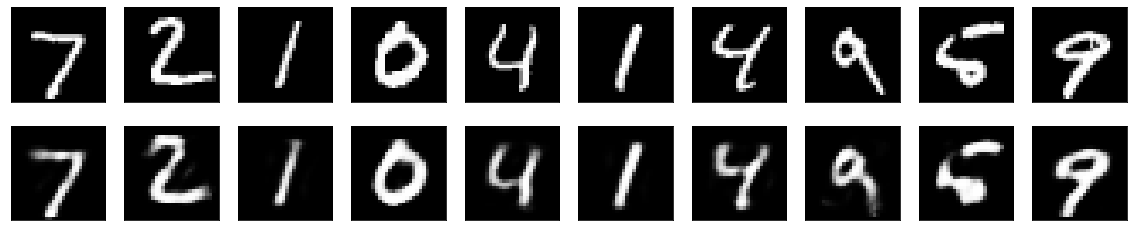

In [10]:
import matplotlib.pyplot as plt


n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(roundtrip_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

What about the compression? Let's check the sizes of the arrays.

In [11]:
encoded_imgs = autoencoder.transform(x_test)
print(f"x_test.shape[1]: {x_test.shape[1]}")
print(f"encoded_imgs.shape[1]: {encoded_imgs.shape[1]}")
cr = round((encoded_imgs.nbytes/x_test.nbytes), 2)
print(f"Compression ratio: 1/{1/cr:.0f}")

x_test.shape[1]: 784
encoded_imgs.shape[1]: 32
Compression ratio: 1/25
